# HouseDiffusion: Vector Floorplan Generation via a Diffusion Model with Discrete and Continuous Denoising

## Introduction

Automatically generating floor plans is a valuable task in architectural design and various creative applications. This paper, "HouseDiffusion: Vector Floorplan Generation via a Diffusion Model with Discrete and Continuous Denoising," introduces a novel approach using a diffusion model for vector-based floor plan generation [1]. Traditional methods often rely on rule-based systems or optimization algorithms, which can be limited in flexibility and efficiency.

## Diffusion Models for Floorplan Generation

Diffusion models are a powerful class of generative models that have achieved impressive results in various domains, including image generation. These models work by gradually adding noise to a clean data sample, resulting in a highly noisy version. The model is then trained to reverse this process, effectively denoising the data step-by-step to recover the original clean sample.


## Idea: Discrete and Continuous Denoising

HouseDiffusion addresses this challenge by incorporating a two-stage denoising process:

**Continuous Denoising:** This stage focuses on recovering precise 2D coordinates of room and door corners from noisy inputs. It treats these coordinates as continuous values and employs the diffusion model's ability to learn and reverse continuous noise addition.

**Discrete Denoising:** This stage refines the geometric relationships between the recovered room corners. It recognizes that floor plans require specific geometric properties, such as wall connections, parallelism, and orthogonality. The model leverages the discrete nature of these relationships to ensure a valid floor plan layout.

## Architecture: Transformer with Graph-based Attention

HouseDiffusion utilizes a Transformer architecture as its core building block. Transformers are well-suited for tasks involving sequential data and relationships between elements. In this case, the sequential data represents the order of visiting room corners during the denoising process.

The model incorporates graph constraints to guide the attention mechanism within the Transformer. A graph is constructed where nodes represent room corners and edges represent potential connections between them. By controlling the attention masks based on this graph, the model focuses on relevant corners during each denoising step, ensuring spatial coherence in the generated floor plan.

## Evaluation and Results

The authors evaluate HouseDiffusion on the RPLAN benchmark dataset(you can see it in download_data.sh), a commonly used collection of floor plan layouts. The model demonstrates competitive performance compared to existing baselines, generating diverse and valid floor plans. Additionally, the ablation studies confirm the effectiveness of the two-stage denoising process and the importance of graph-based attention in achieving high-quality results

## Authors:

**Alper Bahçekapılı** alper.bahcekapili@metu.edu.tr

**Furkan Küçük** kucuk.furkan@metu.edu.tr


## Hyperparameters

* **Batch Size** : 128
* **Learning Rate** : 1e-3
* **ema Rate** : 0.9999
* **Weight Decay** : 0
* **LR Anneal Steps** : 100_000


**Necessary imports**

## Training

In [14]:
import argparse

from model import dist_util, logger
from dataset import load_rplanhg_data
from model.sample import create_named_schedule_sampler
from util.util import (
    create_model_and_diffusion,
)
from model.util import TrainLoop
num_channels = 1024
num_coords = 2
input_channels = 18
condition_channels = 89
out_channels = num_coords * 1

logger.configure()
logger.log("creating models...")

model, diffusion = create_model_and_diffusion(
    input_channels = input_channels,
    condition_channels = condition_channels,
    num_channels = num_channels,
    out_channels = out_channels,
    learn_sigma = False,
    diffusion_steps=1000,
    noise_schedule="cosine",
    timestep_respacing="",
    predict_xstart = False,
    rescale_timesteps = False,
    rescale_learned_sigmas = False,
    analog_bit = False
)
model.to(dist_util.dev())
schedule_sampler = create_named_schedule_sampler("uniform", diffusion)

logger.log("creating data loader...")

data = load_rplanhg_data(
    batch_size=128,
    analog_bit = False,
    target_set=8,
    set_name="train",
    num_points=10
)
logger.log("training...")
TrainLoop(
    model=model,
    diffusion=diffusion,
    data=data,
    batch_size=128,
    microbatch=1,
    lr=1e-4,
    ema_rate=0.9999,
    log_interval=100,
    save_interval=10_000,
    resume_checkpoint="",
    schedule_sampler=schedule_sampler,
    weight_decay=0,
    lr_anneal_steps=100_000,
).run_loop()

Logging to ckpts/openai_2024_05_05_17_43_38_861780
creating models...
Number of model parameters: 86890002
COSINE
creating data loader...
training...


100%|██████████| 6/6 [00:00<00:00, 295.29it/s]
processing dataset: 6it [00:00, 517.30it/s]
/home/alpfischer/METU-Courses/CENG796/house-diffusion/.venv/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Step 0: Updating learning rate to 0.0001
-------------------------
| grad_norm  | 0.269    |
| loss       | 0.0098   |
| loss_q0    | 0.0104   |
| loss_q1    | 0.00859  |
| loss_q2    | 0.00858  |
| loss_q3    | 0.0104   |
| mse_bin    | 0        |
| mse_bin_q0 | 0        |
| mse_bin_q1 | 0        |
| mse_bin_q2 | 0        |
| mse_bin_q3 | 0        |
| mse_dec    | 0.0098   |
| mse_dec_q0 | 0.0104   |
| mse_dec_q1 | 0.00859  |
| mse_dec_q2 | 0.00858  |
| mse_dec_q3 | 0.0104   |
| param_norm | 173      |
| samples    | 128      |
| step       | 0        |
-------------------------
SAVINNNGNGG
saving model 0...
saving model 0.9999...


KeyboardInterrupt: 

Above code trains a model and saves it to ckpts/ folder. There you can find saved models as model_XXXXXX.pt where XXX_XXX means # of steps. After execution is completed you can find a file called progress.csv as well which records the statistics trougout the training

### Visualize the training

dict_keys(['grad_norm', 'loss', 'loss_q0', 'loss_q1', 'loss_q2', 'loss_q3', 'mse_bin', 'mse_bin_q0', 'mse_bin_q1', 'mse_bin_q2', 'mse_bin_q3', 'mse_dec', 'mse_dec_q0', 'mse_dec_q1', 'mse_dec_q2', 'mse_dec_q3', 'param_norm', 'samples', 'step'])


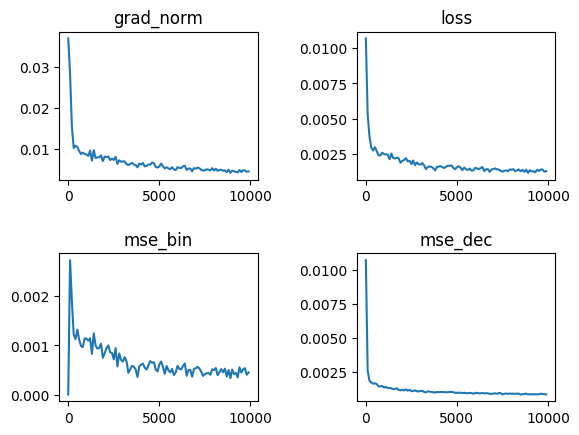

In [15]:
stats = {}
with open("ckpts/10000steps/progress.csv", "r") as f:
    lines = f.readlines()
    keys = lines[0].split(",")

    for l in lines[1:]:
        stats_tmp = l.split(",")
        for i in range(len(keys)):
            k = keys[i].strip()
            if k not in stats:
                stats[k] = []
            stats[k].append(float(stats_tmp[i].strip()))
print(stats.keys())
# grad norm
# loss
# mse_bin
# mse_dec
from matplotlib import pyplot as plt
fig, axis = plt.subplots(nrows=2, ncols=2)
axis[0,0].set_title("grad_norm")
axis[0,0].plot(stats["step"], stats["grad_norm"], )


axis[0,1].set_title("loss")
axis[0,1].plot(stats["step"], stats["loss"], )


axis[1,0].set_title("mse_bin")
axis[1,0].plot(stats["step"], stats["mse_bin"], )


axis[1,1].set_title("mse_dec")
axis[1,1].plot(stats["step"], stats["mse_dec"], )
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust these values as needed

## Load a pretrained model and take samples from it

In [17]:
import argparse

from model import dist_util, logger
from dataset import load_rplanhg_data
from model.sample import create_named_schedule_sampler
from util.util import (
    create_model_and_diffusion
)
from model.util import TrainLoop
import numpy as np
from tqdm import tqdm
import webcolors
import networkx as nx
from collections import defaultdict
from shapely.geometry import Polygon
from shapely.geometry.base import geom_factory
from shapely.geos import lgeos
import io
import PIL.Image as Image
import drawsvg as drawsvg
import cairosvg
import imageio
from image_sample import estimate_graph

MODEL_PATH=  "ckpts/10000steps/model010000.pt"

num_channels = 512
num_coords = 2
input_channels = 18
condition_channels = 89
out_channels = num_coords * 1

logger.configure()
logger.log("creating models...")

model, diffusion = create_model_and_diffusion(
    analog_bit = False,
    input_channels = input_channels,
    condition_channels = condition_channels,
    num_channels = num_channels,
    out_channels = out_channels, 
    learn_sigma = False,
    diffusion_steps=1000,
    noise_schedule="cosine",
    timestep_respacing="",
    predict_xstart = False,
    rescale_timesteps = False,
    rescale_learned_sigmas = False
)

model.load_state_dict(
    dist_util.load_state_dict(MODEL_PATH, map_location="cpu")
)

model.to(dist_util.dev())
model.eval()

ID_COLOR = {1: '#EE4D4D', 2: '#C67C7B', 3: '#FFD274', 4: '#BEBEBE', 5: '#BFE3E8',
            6: '#7BA779', 7: '#E87A90', 8: '#FF8C69', 10: '#1F849B', 11: '#727171',
            13: '#785A67', 12: '#D3A2C7'}
num_room_types = 14
data = load_rplanhg_data(
    batch_size=128,
    analog_bit=False,
    set_name="eval",
    target_set=8,
)
graph_errors = []
model_kwargs = {}
sample_fn = (
    diffusion.p_sample_loop 
)
data_sample, model_kwargs = next(data)
for key in model_kwargs:
    model_kwargs[key] = model_kwargs[key].cuda()

sample = sample_fn(
    model,
    data_sample.shape,
    clip_denoised=True,
    model_kwargs=model_kwargs
)
sample_gt = data_sample.cuda().unsqueeze(0)
sample = sample.permute([0, 1, 3, 2])
sample_gt = sample_gt.permute([0, 1, 3, 2])
import os
os.makedirs('./outputs/pred', exist_ok=True)
os.makedirs('./outputs/gt', exist_ok=True)
os.makedirs('./outputs/gif', exist_ok=True)
os.makedirs('./outputs/graphs_gt', exist_ok=True)
os.makedirs('./outputs/graphs_pred', exist_ok=True)
        

def visualize_inference(sample, unique_id=-1, calculate_scores = False, dataset_portion = 8):
    gifs = []
    for i in tqdm(range(sample.shape[1])):
        resolution = 256
        images = []
        images2 = []
        images3 = []
        for k in range(sample.shape[0]):
            # Create 
            draw = drawsvg.Drawing(resolution, resolution, displayInline=False)
            draw.append(drawsvg.Rectangle(0,0,resolution,resolution, fill='black'))
            draw2 = drawsvg.Drawing(resolution, resolution, displayInline=False)
            draw2.append(drawsvg.Rectangle(0,0,resolution,resolution, fill='black'))
            draw3 = drawsvg.Drawing(resolution, resolution, displayInline=False)
            draw3.append(drawsvg.Rectangle(0,0,resolution,resolution, fill='black'))
            
            draw_color = drawsvg.Drawing(resolution, resolution, displayInline=False)
            draw_color.append(drawsvg.Rectangle(0,0,resolution,resolution, fill='white'))
            polys = []
            types = []
            for j, point in (enumerate(sample[k][i])):
                if model_kwargs[f'src_key_padding_mask'][i][j]==1:
                    continue
                point = point.cpu().data.numpy()
                if j==0:
                    poly = []
                if j>0 and (model_kwargs[f'room_indices'][i, j]!=model_kwargs[f'room_indices'][i, j-1]).any():
                    polys.append(poly)
                    types.append(c)
                    poly = []
                pred_center = False
                if pred_center:
                    point = point/2 + 1
                    point = point * resolution//2
                else:
                    point = point/2 + 0.5
                    point = point * resolution
                poly.append((point[0], point[1]))
                c = np.argmax(model_kwargs[f'room_types'][i][j-1].cpu().numpy())
            polys.append(poly)
            types.append(c)
            door_indices = [11, 12, 13]
            for poly, c in zip(polys, types):
                if c in door_indices or c==0:
                    continue
                room_type = c
                c = webcolors.hex_to_rgb(ID_COLOR[c])
                draw_color.append(drawsvg.Lines(*np.array(poly).flatten().tolist(), close=True, fill=ID_COLOR[room_type], fill_opacity=1.0, stroke='black', stroke_width=1))
                draw.append(drawsvg.Lines(*np.array(poly).flatten().tolist(), close=True, fill='black', fill_opacity=0.0, stroke=webcolors.rgb_to_hex([int(x/2) for x in c]), stroke_width=0.5*(resolution/256)))
                draw2.append(drawsvg.Lines(*np.array(poly).flatten().tolist(), close=True, fill=ID_COLOR[room_type], fill_opacity=1.0, stroke=webcolors.rgb_to_hex([int(x/2) for x in c]), stroke_width=0.5*(resolution/256)))
                for corner in poly:
                    draw.append(drawsvg.Circle(corner[0], corner[1], 2*(resolution/256), fill=ID_COLOR[room_type], fill_opacity=1.0, stroke='gray', stroke_width=0.25))
                    draw3.append(drawsvg.Circle(corner[0], corner[1], 2*(resolution/256), fill=ID_COLOR[room_type], fill_opacity=1.0, stroke='gray', stroke_width=0.25))
            for poly, c in zip(polys, types):
                if c not in door_indices:
                    continue
                room_type = c
                c = webcolors.hex_to_rgb(ID_COLOR[c])
                draw_color.append(drawsvg.Lines(*np.array(poly).flatten().tolist(), close=True, fill=ID_COLOR[room_type], fill_opacity=1.0, stroke='black', stroke_width=1))
                draw.append(drawsvg.Lines(*np.array(poly).flatten().tolist(), close=True, fill='black', fill_opacity=0.0, stroke=webcolors.rgb_to_hex([int(x/2) for x in c]), stroke_width=0.5*(resolution/256)))
                draw2.append(drawsvg.Lines(*np.array(poly).flatten().tolist(), close=True, fill=ID_COLOR[room_type], fill_opacity=1.0, stroke=webcolors.rgb_to_hex([int(x/2) for x in c]), stroke_width=0.5*(resolution/256)))
                
                for corner in poly:
                    draw.append(drawsvg.Circle(corner[0], corner[1], 2*(resolution/256), fill=ID_COLOR[room_type], fill_opacity=1.0, stroke='gray', stroke_width=0.25))
                    draw3.append(drawsvg.Circle(corner[0], corner[1], 2*(resolution/256), fill=ID_COLOR[room_type], fill_opacity=1.0, stroke='gray', stroke_width=0.25))
            images.append(Image.open(io.BytesIO(cairosvg.svg2png(draw.as_svg()))))
            images2.append(Image.open(io.BytesIO(cairosvg.svg2png(draw2.as_svg()))))
            images3.append(Image.open(io.BytesIO(cairosvg.svg2png(draw3.as_svg()))))

            if k==sample.shape[0]-1:
                if 'graph' in model_kwargs:
                    graph_errors.append(estimate_graph(i, polys, types, model_kwargs[f'graph'][i], ID_COLOR=ID_COLOR, draw_graph=True, save_svg=True))
                else:
                    graph_errors.append(0)
        
        gifs.append(images)
        imageio.mimwrite(f'outputs/gif/{i}.gif', images, fps=10, loop=1)
        imageio.mimwrite(f'outputs/gif/{i}_v2.gif', images2, fps=10, loop=1)
        imageio.mimwrite(f'outputs/gif/{i}_v3.gif', images3, fps=10, loop=1)
        if calculate_scores:
            Image.open(io.BytesIO(cairosvg.svg2png(draw_color.as_svg()))).save(f'outputs/{dataset_portion}/{i}c_{k}_{unique_id}_{dataset_portion}.png')


gif_gt = visualize_inference(sample_gt)
gif_sample = visualize_inference(sample)
# fid_score = calculate_fid_given_paths(['outputs/gt', 'outputs/pred'], 64, 'cuda', 2048)
# print(f'FID: {fid_score}')
# print(f'Compatibility: {np.mean(graph_errors)}')
# errors.append([fid_score, np.mean(graph_errors)])




Logging to ckpts/openai_2024_05_05_17_44_20_049463
creating models...


TypeError: create_model_and_diffusion() missing 1 required positional argument: 'analog_bit'

### Viusalize the gifs

![CornersLocal](static/0.gif)
![RoomsLocal](static/0_v2.gif)

### Regenerate the metrics

In our proposal we wanted to reproduce following two results:

![Qualitative Result](static/quantative_target.png)

_Last row of the following table_

![Quantative Result](static/table1.png)


The qualitative result is given in the preceding cell as a gif. If you think there is a problem with it please contact us.

The Diversity field in the table is FID score. This score should be calculated among the test split of the dataset. In the following cell you can see the calculation of this score

In [38]:
from pytorch_fid.fid_score import calculate_fid_given_paths

DATASET_SPLIT = 8
NUM_POINTS = 4


test_dataloader = load_rplanhg_data(
    batch_size=128,
    set_name=eval,
    analog_bit=False,
    num_points=NUM_POINTS,
    target_set=DATASET_SPLIT)
model.eval()

graph_errors = []
model_kwargs = {}
sample_fn = (
    diffusion.p_sample_loop 
)

graph_errors = []
fid_scores = []
for i in tqdm(range(NUM_POINTS)):
    data_sample, model_kwargs = next(data)
    for key in model_kwargs:
        model_kwargs[key] = model_kwargs[key].cuda()

    sample = sample_fn(
        model,
        data_sample.shape,
        clip_denoised=True,
        model_kwargs=model_kwargs,
        analog_bit=False,
    )
    sample_gt = data_sample.cuda().unsqueeze(0)
    sample = sample.permute([0, 1, 3, 2])
    sample_gt = sample_gt.permute([0, 1, 3, 2])
    
    graph_error = visualize_inference(sample_gt, dataset_portion='gt', calculate_scores=True, unique_id = i)
    graph_error = visualize_inference(sample, dataset_portion='pred', calculate_scores=True, unique_id = i)
fid_score = calculate_fid_given_paths(['./outputs/gt', './outputs/pred'], 64, 'cuda', 2048)
print(f'FID: {fid_score}')


1000it [00:08, 115.85it/s]0<?, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
1000it [00:08, 120.32it/s]0<00:32, 10.86s/it]
100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
1000it [00:08, 119.79it/s]1<00:21, 10.65s/it]
100%|██████████| 1/1 [00:01<00:00,  1.90s/it]
1000it [00:08, 119.73it/s]1<00:10, 10.60s/it]
100%|██████████| 4/4 [00:42<00:00, 10.62s/it]


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


FID: 215.00051101741315


As you see we were able to get the FID score of 215. However this value was ~10 in the paper(diversity column). We are planning to improve this in v2 submission

# Challanges and Development Notes

1. **Dataset Related Problems**

Because the dataset is not directly images we have stumbled upon a lot of difficulties while dealing with it. 

1.1. Before Loading

First as you can see from the paper' s repository they mention that at the data preprocessing step, they are using a [pre-existing repository](https://github.com/sepidsh/Housegan-data-reader). While this repository is useful to load a portion of the data lacks completeness. While we were experimenting with this loader code we saw that, some of the data point given in the [dataset](https://docs.google.com/forms/d/e/1FAIpQLSfwteilXzURRKDI5QopWCyOGkeb_CFFbRwtQ0SOPhEg0KGSfw/viewform) is problematic. In order to overcome this barrirer, we needed to make a lot of update to the given code and skip those entries that still cause problems.

Even after overcoming this issue, existing code(the one that converts existing data to json files which is more suitable to load and use it before training) was expected to be executed in ~40 hours. We needed to parallelize this process and at the and we were able to reduce this step to ~5 hours. Then we had access to ~80_000 sample json files

1.2 From json to numpy


After we solve the preceding problem and convert existing dataset to json files, we needed to solve dataset saving/loading problems. Because we have varying number of rooms or number of vertices in floorplan graphs, we could not save all the information into a numpy compressed file. Because in recent versions of numpy directly saving ragged arrays while preserving data type is not allowed. This step could allow us to skip the preprocess step before training(from json to numpy arrays) however we decided to move on and arrange our code so that each time we train our model, we preprocess from the ground.

2. **Model Related Problems**

During development of diffusion model(transformer model is being developed but we did not yet encounter a major problem to mention) we have face a lot of problems related to dimensionalities. We overcome the issue by carefully debugging as we make changes in the codebase.

3. **Visualization Related Problems**

Because our data is visualized as svgs usual ways of displaying images we not suitable in our cases. We needed to make use of a lot of libraries. 

4. **Training Related Problems**

We could not train our model with a large portion of the data. We were able to train with relatively small portion of it (10_000/~60_000) with comparably large number of steps. We have tried this approach because we wanted to make sure the model is learning the way it needs to. When 1_000 step trained model and 10_000 step trained models are compare we can clearly see that model is learning as the # of steps increase. Unfortunately, after we validate everything is working as expected we could not train the model with more data. We are planning to work on this end until v2 submission.
